In [1]:
# **Step 2: The Python Script (`train_snake.py`)**

import sys
sys.path.insert(0, '..')  # Add parent directory to path

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import elastica as ea
from collections import defaultdict
from typing import Optional
from numpy.typing import NDArray
# from PyElastica.elastica.timestepper.symplectic_steppers import do_step
# from PyElastica.elastica.timestepper import extend_stepper_interface
from elastica.typing import RodType


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

import matplotlib.pyplot as plt

import os
import json
from pathlib import Path

from snake_env import FixedWavelengthXZOnlyContinuumSnakeEnv
import config

In [2]:
from Utilities.visualization import visualization

v1 = visualization()



In [3]:
# Reload config module to get latest changes
import importlib
importlib.reload(config)

config.ENV_CONFIG["_n_elem"] = 10

env = FixedWavelengthXZOnlyContinuumSnakeEnv(
    fixed_wavelength=config.ENV_CONFIG["fixed_wavelength"],
    obs_keys=config.ENV_CONFIG["obs_keys"],
)

# Configure environment parameters
env.period = config.ENV_CONFIG["period"]
env.ratio_time = config.ENV_CONFIG["ratio_time"]
env.rut_ratio = config.ENV_CONFIG["rut_ratio"]
env._n_elem = config.ENV_CONFIG["_n_elem"]
env.max_episode_length = config.ENV_CONFIG["max_episode_length"]*100
env.reward_weights = config.REWARD_WEIGHTS

obs, _ = env.reset()

In [4]:
env._n_elem

10

In [107]:
# Get the project root directory (parent of 'developing')
# Since this notebook is in the 'developing' folder, go up one level to get project root
current_dir = Path.cwd()
if current_dir.name == 'developing':
    project_root = current_dir.parent
else:
    project_root = current_dir

model_path = project_root / "Training" / "Saved_Models" / "PPO_Snake_Model"


In [8]:

print(f"\nLoading model from {model_path}...")
if not model_path.with_suffix('.zip').exists():
    print(f"Error: Model file not found at {model_path}.zip")
else:
    model = PPO.load(str(model_path), env=env)
    print("Model loaded successfully!")



Loading model from /Users/wenqifan/Desktop/RL-ElasticaSnake/Training/Saved_Models/PPO_Snake_Model...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully!


In [4]:
import contextlib
import io

# Configuration
num_steps = 3000  # Number of steps to run
use_model = True  # Set to True to use model.predict(), False to use manual actions
verbose = True  # Set to True to print step-by-step information

# Manual action (used when use_model=False)
# Action space is normalized to [-1, 1]
# manual_action = np.array([5e-3,5e-3,5e-3,5e-3,5e-3,5e-3], dtype=np.float32)
manual_action = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-3], dtype=np.float32)
# manual_action = np.array([-5e-3,5e-3,5e-3,-5e-3,5e-3,-5e-3], dtype=np.float32)
# manual_action = np.array([1,2,3,4,5,6], dtype=np.float32)
# manual_action = np.array([1,-5,-8,-8,-5,1], dtype=np.float32) #weird action
# manual_action = np.array([-10,-10,10,10,-10,-10], dtype=np.float32)


manual_action = manual_action * 10


# Reset environment
obs, _ = env.reset()

# Tracking variables
total_reward = 0.0
episode_reward = 0.0
episode_count = 0

print(f"Running {num_steps} steps in environment...")
print(f"Mode: {'Model predictions' if use_model else 'Manual actions'}")
if not use_model:
    print(f"Manual action: {manual_action}")
print("=" * 70)


Running 3000 steps in environment...
Mode: Model predictions


In [5]:

# Main loop
for step in range(num_steps):
    
    # action, _states = model.predict(obs, deterministic=True)

    action = manual_action.copy()
    
    # Step environment (suppress stdout from elastica)
    with contextlib.redirect_stdout(io.StringIO()):
        obs, reward, terminated, truncated, info = env.step(action)
    
    # Accumulate rewards
    total_reward += reward
    episode_reward += reward
    
    # Print step information
    if verbose:
        current_time = info.get('current_time', 0.0)
        position = info.get('position', [0.0, 0.0, 0.0])
        forward_speed = info.get('forward_speed', info.get('velocity_projection', 0.0))
        lateral_speed = info.get('lateral_speed', info.get('speed_perpendicular_to_target', 0.0))
        
        print(f"Step {step+1}/{num_steps} | "
              f"Time: {current_time:.3f}s | "
              f"Reward: {reward:.4f} | "
              f"Pos: [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}] | "
              f"Forward: {forward_speed:.4f} m/s | "
              f"Lateral: {lateral_speed:.4f} m/s")
    
    # Check if episode ended
    if terminated or truncated:
        episode_count += 1
        if verbose:
            print(f"\nEpisode {episode_count} ended at step {step+1}")
            print(f"  Episode reward: {episode_reward:.4f}")
            print(f"  Final position: {info.get('position', [0, 0, 0])}")
        obs, _ = env.reset()
        episode_reward = 0.0
        if verbose:
            print("Environment reset\n")

# Print summary
print("\n" + "=" * 70)
print("Evaluation Summary:")
print(f"  Total steps: {num_steps}")
print(f"  Episodes completed: {episode_count}")
print(f"  Total reward: {total_reward:.4f}")
print(f"  Average reward per step: {total_reward/num_steps:.4f}")
print("=" * 70)


Step 1/3000 | Time: 0.011s | Reward: -32.7167 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0000 m/s | Lateral: 0.0000 m/s
Step 2/3000 | Time: 0.022s | Reward: -32.4164 | Pos: [-0.000, 0.000, 0.175] | Forward: -0.0000 m/s | Lateral: 0.0000 m/s
Step 3/3000 | Time: 0.033s | Reward: -40.2559 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0000 m/s | Lateral: 0.0000 m/s
Step 4/3000 | Time: 0.044s | Reward: -46.4955 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0001 m/s | Lateral: 0.0000 m/s
Step 5/3000 | Time: 0.055s | Reward: -45.2993 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0002 m/s | Lateral: 0.0000 m/s
Step 6/3000 | Time: 0.066s | Reward: -40.3121 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0005 m/s | Lateral: 0.0000 m/s
Step 7/3000 | Time: 0.077s | Reward: -43.1366 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0002 m/s | Lateral: 0.0000 m/s
Step 8/3000 | Time: 0.088s | Reward: -39.1385 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0002 m/s | Lateral: 0.0000 m/s
Step 9/3000 | Time: 0.099s | Reward: -43.9873 

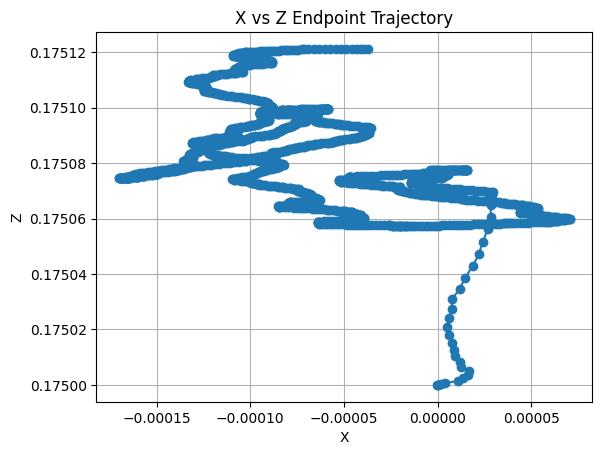

In [6]:

# Visualize trajectory in 2D (X vs Z)
avg_positions = np.asarray(env.state_dict['avg_position'])
# v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])

# Visualize velocity norm history
avg_velocities = np.asarray(env.state_dict['avg_velocity'])
# v1.velocity_norm_history(env.state_dict['time'], avg_velocities)

# Visualize trajectory in 3D
# v1.trajectory_3d(avg_positions)

v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])


In [ ]:

# plt.plot(env.state_dict['time'], env.state_dict['reward'])


# Visualize current snake shape
# v1.current_shape_3d(env.shearable_rod)

# Plot video from callback data
# v1.plot_video(env.callback_data)

v1.plot_video_auto_limits(
    env.callback_data,
    "video_auto_limits.mp4",
    1500,
)



Plotting limited video: using 1500 of 1969 frames, 45.50 fps, 32.97 seconds duration


 26%|██▌       | 386/1499 [00:06<00:22, 49.58it/s]